In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute

# Get the data from the .csv file
df = pd.read_csv('kmeans_data.csv',
    usecols=['Feature 1', 'Feature 2', 'Class'])


In [2]:
df.head()

,Feature 1,Feature 2,Class
0,-0.646,0.763,Green
1,-0.610,0.617,Green
2,-0.596,0.915,Green
3,-0.565,0.927,Green
4,-0.542,0.631,Green


In [3]:
# Change categorical data to number 0-2
df["Class"] = pd.Categorical(df["Class"])
df["Class"] = df["Class"].cat.codes
# Change dataframe to numpy matrix
data = df.values[:, 0:2]
category = df.values[:, 2]

[[-0.25  0.2 ]
 [ 0.   -0.1 ]
 [ 0.25  0.35]]


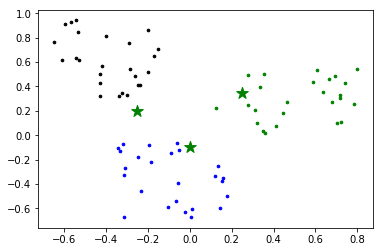

In [64]:
# Number of clusters
k = 3
# Number of training data
n = data.shape[0]
# Number of features in the data
c = data.shape[1]

# Generate random centers, here we use sigma and mean to ensure it represent the whole data
mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)
centers = np.random.randn(k,c)*std + mean

centers = np.array([[-0.25, 0.2], [0, -0.1], [0.25, 0.35]])
print(centers)

# Plot the data and the centers generated as random
colors=['green', 'blue', 'black']
for i in range(n):
    plt.scatter(data[i, 0], data[i,1], s=7, color = colors[int(category[i])])
plt.scatter(centers[:,0], centers[:,1], marker='*', c='g', s=150)

In [67]:
def point_centroid_distances(point, centroids):
    
    # Calculating theta and phi values
    phi_list = [((x + 1) * pi / 2) for x in [point[0], centroids[0][0], centroids[1][0], centroids[2][0]]]
    theta_list = [((x + 1) * pi / 2) for x in [point[1], centroids[0][1], centroids[1][1], centroids[2][1]]]

    # Create a 2 qubit QuantumRegister - two for the vectors, and 
    # one for the ancillary qubit
    qreg = QuantumRegister(3, 'qreg')

    # Create a one bit ClassicalRegister to hold the result
    # of the measurements
    creg = ClassicalRegister(1, 'creg')

    qc = QuantumCircuit(qreg, creg, name='qc')

    # Get backend using the Aer provider
    backend = Aer.get_backend('qasm_simulator')

    # Create list to hold the results
    results_list = []

    # Estimating distances from the new point to the centroids
    for i in range(1, 4):
        # Apply a Hadamard to the ancillary
        qc.h(qreg[2])

        # Encode new point and centroid
        qc.u3(theta_list[0], phi_list[0], 0, qreg[0])           
        qc.u3(theta_list[i], phi_list[i], 0, qreg[1]) 

        # Perform controlled swap
        qc.cswap(qreg[2], qreg[0], qreg[1])
        # Apply second Hadamard to ancillary
        qc.h(qreg[2])

        # Measure ancillary
        qc.measure(qreg[2], creg[0])

        # Reset qubits
        qc.reset(qreg)

        # Register and execute job
        job = execute(qc, backend=backend, shots=1024)
        result = job.result().get_counts(qc)
        try:
            results_list.append(result['1'])
        except:
            results_list.append(0)


    return results_list

In [69]:
centers_old = np.zeros(centers.shape) # to store old centers
centers_new = deepcopy(centers) # Store new centers

data.shape
clusters = np.zeros(n)
distances = np.zeros((n,k))

error = np.linalg.norm(centers_new - centers_old)

# When, after an update, the estimate of that center stays the same, exit loop
while error != 0:
    # Measure the distance to every center
    
    
    distances = np.array(list(map(lambda x: point_centroid_distances(x, centers), data)))

    # Assign all training data to closest center
    clusters = np.argmin(distances, axis = 1)
    
    centers_old = deepcopy(centers_new)
    # Calculate mean for every cluster and update the center
    for i in range(k):
        centers_new[i] = np.mean(data[clusters == i], axis=0)
    error = np.linalg.norm(centers_new - centers_old)
    print(error)
centers_new

0.4038026849367525
0.03296050934389667
0.05476546812237344


KeyboardInterrupt: 

In [ ]:
# Plot the data and the centers generated as random
for i in range(n):
    plt.scatter(data[i, 0], data[i,1], s=7, color = colors[int(category[i])])
plt.scatter(centers_new[:,0], centers_new[:,1], marker='*', c='g', s=150)